In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import os, time, sys
import psutil
from datetime import timedelta
from itertools import product

import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.stats import linregress, invgauss, expon
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

import pcms.haar
import pcms.tree
import utils

In [136]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

### Random topology CDF

#### Evaluate at a single point

In [82]:
n_leaves = 1000
f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g
y = 0.01

In [83]:
start = time.time()
cdf_val_cbst = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
print("Elapsed time: ", time.time() - start)

KeyboardInterrupt: 

In [ ]:
print(cdf_val_cbst)

1.0


#### Estimate time complexity

In [ ]:
process = psutil.Process()

sizes1 = np.logspace(1, 5, num=15, dtype=int)
times1 = []
memories1 = []

for n_leaves in sizes1:
    f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    func = f - g
    y = 0.01

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times1.append(elapsed)
    memories1.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_leaves = {n_leaves:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_leaves =      10 | time = 0.42743 sec | memory change = -0.01 MB
n_leaves =      19 | time = 0.43613 sec | memory change = 0.00 MB
n_leaves =      37 | time = 0.50831 sec | memory change = 0.00 MB


KeyboardInterrupt: 

Fit: T(n) ≈ 0.00345485 * n^1.01 (after burn-in=5)


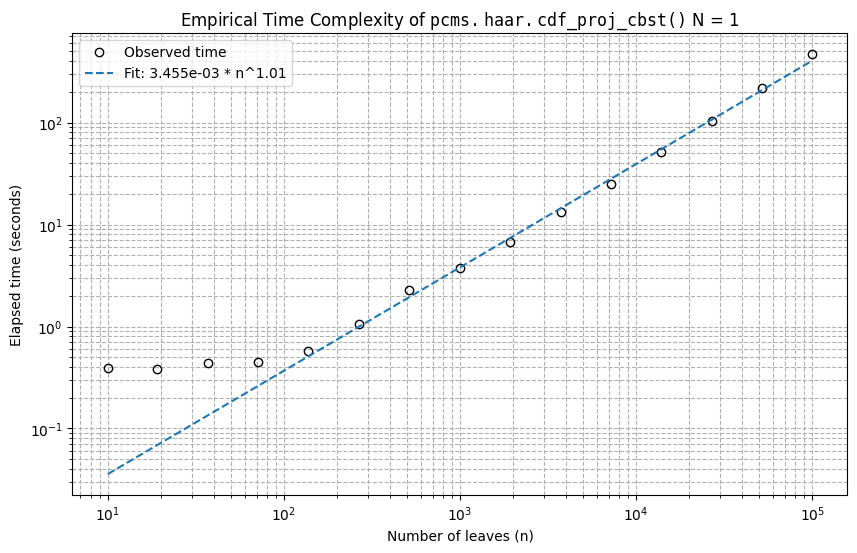

In [ ]:
burn_in = 5

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes1)
log_times = np.log10(times1)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes1**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes1, times1,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes1, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of leaves (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [ ]:
process = psutil.Process()

sizes2 = np.logspace(1, 8, num=15, dtype=int)
times2 = []
memories2 = []
n_leaves = 1000

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for n_points in sizes2:
    y = np.linspace(0, 0.1, n_points)

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times2.append(elapsed)
    memories2.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_points = {n_points:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_points =      10 | time = 3.96964 sec | memory change = 0.21 MB
n_points =      31 | time = 3.83084 sec | memory change = 0.00 MB
n_points =     100 | time = 3.84262 sec | memory change = 0.00 MB
n_points =     316 | time = 3.79303 sec | memory change = 0.00 MB
n_points =    1000 | time = 4.36598 sec | memory change = -0.01 MB
n_points =    3162 | time = 3.92913 sec | memory change = 0.01 MB
n_points =   10000 | time = 3.94084 sec | memory change = 0.00 MB
n_points =   31622 | time = 3.96067 sec | memory change = -0.01 MB
n_points =  100000 | time = 4.03930 sec | memory change = 11.40 MB
n_points =  316227 | time = 4.07176 sec | memory change = 4.17 MB
n_points = 1000000 | time = 4.11871 sec | memory change = 19.50 MB
n_points = 3162277 | time = 3.72065 sec | memory change = 23.71 MB
n_points = 10000000 | time = 3.77556 sec | memory change = 52.20 MB
n_points = 31622776 | time = 3.84717 sec | memory change = 164.97 MB
n_points = 100000000 | time = 4.30723 sec | memory change = 521.68

Fit: T(n) ≈ 3.91876 * n^0.00 (after burn-in=0)


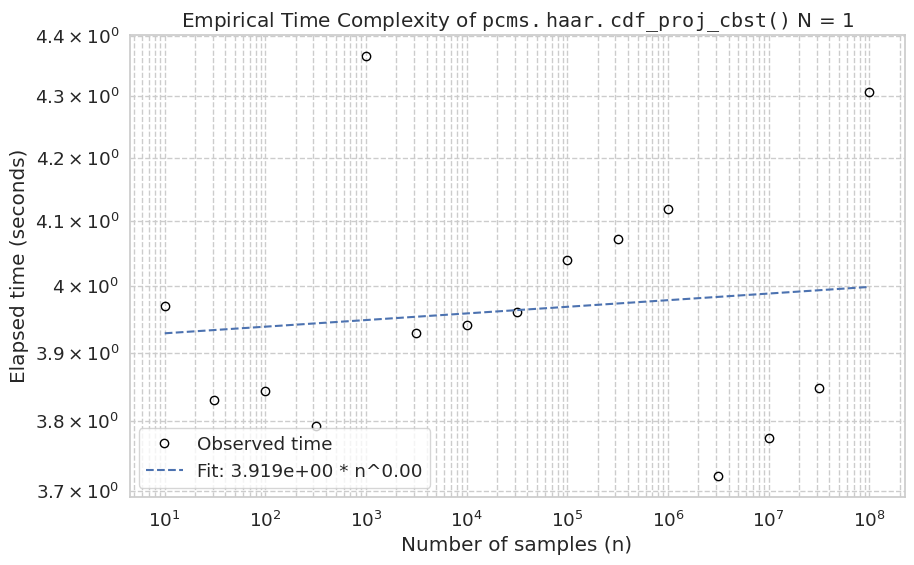

In [ ]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes2)
log_times = np.log10(times2)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes2**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes2, times2,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes2, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of samples (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [ ]:
process = psutil.Process()

sizes3 = np.logspace(0, 3, num=8, dtype=int)
times3 = []
memories3 = []
n_leaves = 1000
y = 0.01

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for batch_size in sizes3:
    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=batch_size)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times3.append(elapsed)
    memories3.append(mem_after - mem_before)  # memory difference in MB

    print(f"batch_size = {batch_size:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

batch_size =       1 | time = 35.67350 sec | memory change = 0.00 MB
batch_size =       2 | time = 19.26267 sec | memory change = 0.00 MB
batch_size =       7 | time = 10.23794 sec | memory change = 0.20 MB
batch_size =      19 | time = 7.44545 sec | memory change = -0.01 MB
batch_size =      51 | time = 5.21468 sec | memory change = -0.02 MB
batch_size =     138 | time = 4.30055 sec | memory change = 0.01 MB
batch_size =     372 | time = 3.82171 sec | memory change = 0.01 MB
batch_size =    1000 | time = 3.41441 sec | memory change = 0.00 MB


Fit: T(n) ≈ 23.9613 * n^-0.33 (after burn-in=0)


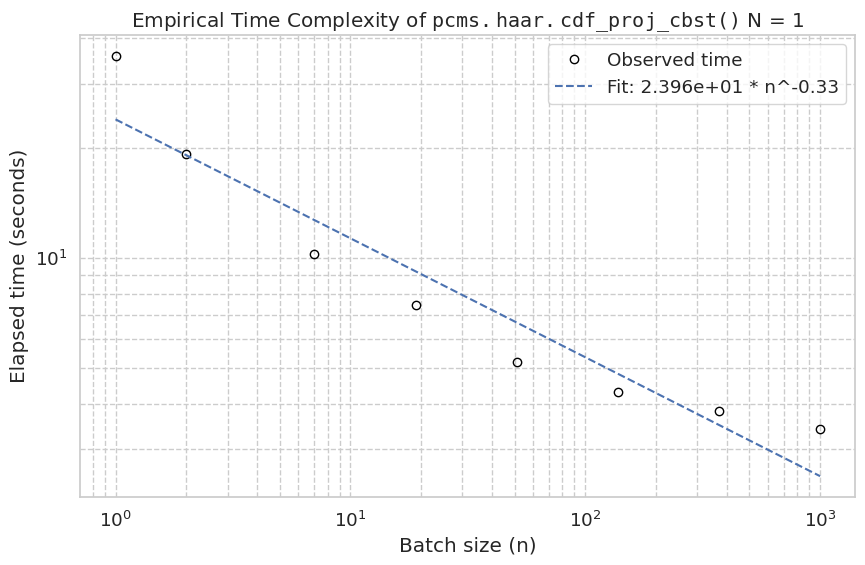

In [ ]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes3)
log_times = np.log10(times3)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes3**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes3, times3,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes3, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Batch size (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

#### Evaluate at multiple points

In [ ]:
n_points = 1000
ys_cbst = np.linspace(-0.0001, 0.0001, n_points)

In [ ]:
cdf_vals_cbst = pcms.haar.cdf_proj_cbst(ys_cbst, func, eps=0.005, delta=0.01)

In [ ]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_cbst = np.interp(quantile_levels, cdf_vals_cbst, ys_cbst)
quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst = quantiles_cbst

In [ ]:
print(quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst)

4.7472013621519845e-06 2.593849323776331e-05 5.0493410076743415e-05 8.121698621698616e-05


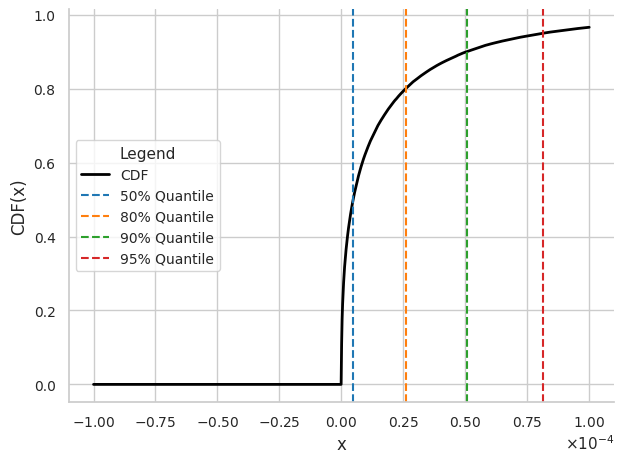

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_cbst, cdf_vals_cbst, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_cbst, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_cbst, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_cbst, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_cbst, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

### Difference of Dirichlets CDF

#### Evaluate at a single point

In [ ]:
n_leaves = 1000
tree = pcms.tree.cbst(n_leaves=n_leaves)
y = 0.04
eps = 0.01
delta = 0.01

In [ ]:
node = np.random.choice(tree.find_interior_nodes())

In [ ]:
cdf_val_dod = pcms.haar.cdf_proj_dod(y, tree, node=node)

In [ ]:
print(cdf_val_dod)

1.0


#### Evaluate at multiple points

In [ ]:
n_points = 1000
ys_dod = np.linspace(-0.01, 0.01, n_points)

In [ ]:
cdf_vals_dod = pcms.haar.cdf_proj_dod(ys_dod, tree, node=node)

In [ ]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_dod = np.interp(quantile_levels, cdf_vals_dod, ys_dod)
quant50_dod, quant80_dod, quant90_dod, quant95_dod = quantiles_dod

In [ ]:
print(quant50_dod, quant80_dod, quant90_dod, quant95_dod)

1.5737386871405864e-06 0.0024869083643030004 0.003909793664632373 0.005174799799799798


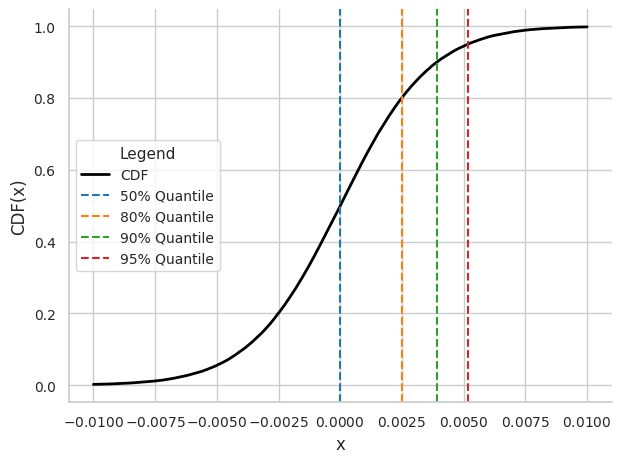

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_dod, cdf_vals_dod, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_dod, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_dod, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_dod, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_dod, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [137]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [138]:
interior_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [139]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Guerrero Negro dataset

In [140]:
gn_table_filepath = os.path.join(GN_DATA, '454/47908_otu_table.tsv')
table_df = utils.load_gn_seq_id_abundances(gn_table_filepath)

In [141]:
# Convert counts to proportions
cols = table_df.columns[1:]
table_df[cols] = table_df[cols].div(table_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[table_df['OTU ID']].values
table_df.loc[:, 'Leaf Index'] = leaf_idxs
table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [142]:
print(table_df)

       OTU ID  1200.GN01P  1200.GN01P.o  1200.GN02P  1200.GN02P.o  1200.GN03P  \
0     2773512    0.000000           0.0    0.000000      0.000602    0.000000   
1     4361967    0.000000           0.0    0.000000      0.000602    0.000000   
2     3675511    0.001170           0.0    0.001155      0.000000    0.000696   
3     2877492    0.000000           0.0    0.000578      0.000000    0.001392   
4     4481520    0.000000           0.0    0.000000      0.000000    0.008351   
...       ...         ...           ...         ...           ...         ...   
1700  4331263    0.000000           0.0    0.000000      0.000000    0.000000   
1701   252805    0.000585           0.0    0.001733      0.003008    0.000696   
1702  4453795    0.000000           0.0    0.000000      0.000000    0.001392   
1703  1549742    0.000000           0.0    0.000000      0.000000    0.000000   
1704  1636411    0.000000           0.0    0.000000      0.000000    0.000000   

      1200.GN03P.o  1200.GN

### Compute Haar-like coordinates

In [143]:
Q, S = pcms.haar.sparsify(tree)

In [144]:
a_s = table_df['1200.GN09P.o']
b_s = table_df['1200.GN01P.o']

indices = table_df['Leaf Index'].values
n_leaves = tree.find_leaves().size

a_vals = a_s.values
a = np.zeros((n_leaves,))
a[indices] = a_vals

b_vals = b_s.values
b = np.zeros((n_leaves,))
b[indices] = b_vals

diff = a - b

In [145]:
hl_coords = Q.T @ diff
dh_comps = hl_coords**2 * S.diagonal()

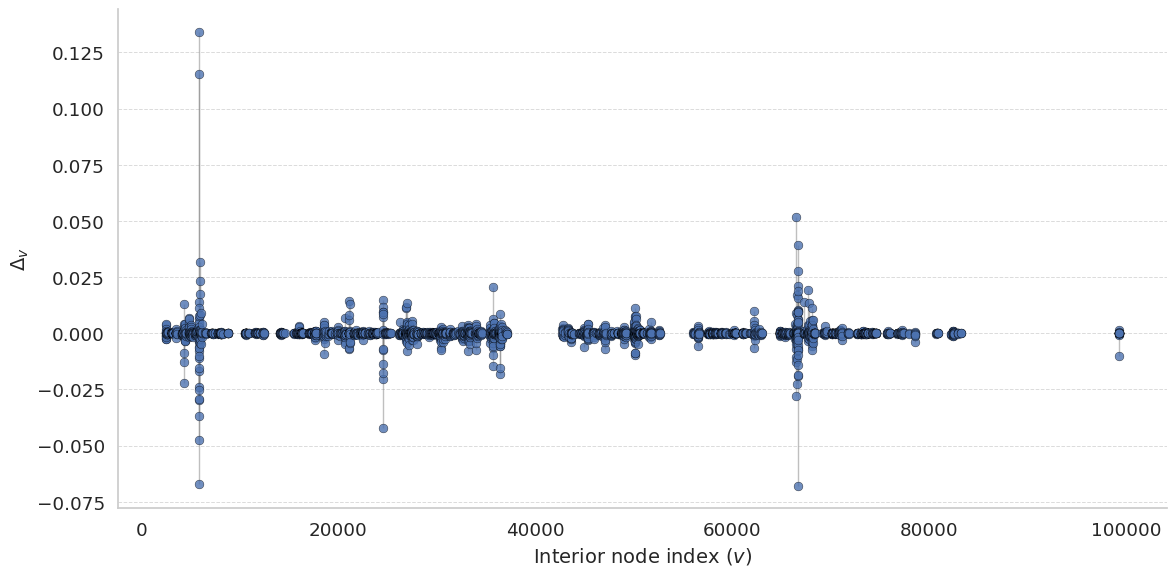

In [146]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx

# Scatter points colored by value with better aesthetics
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

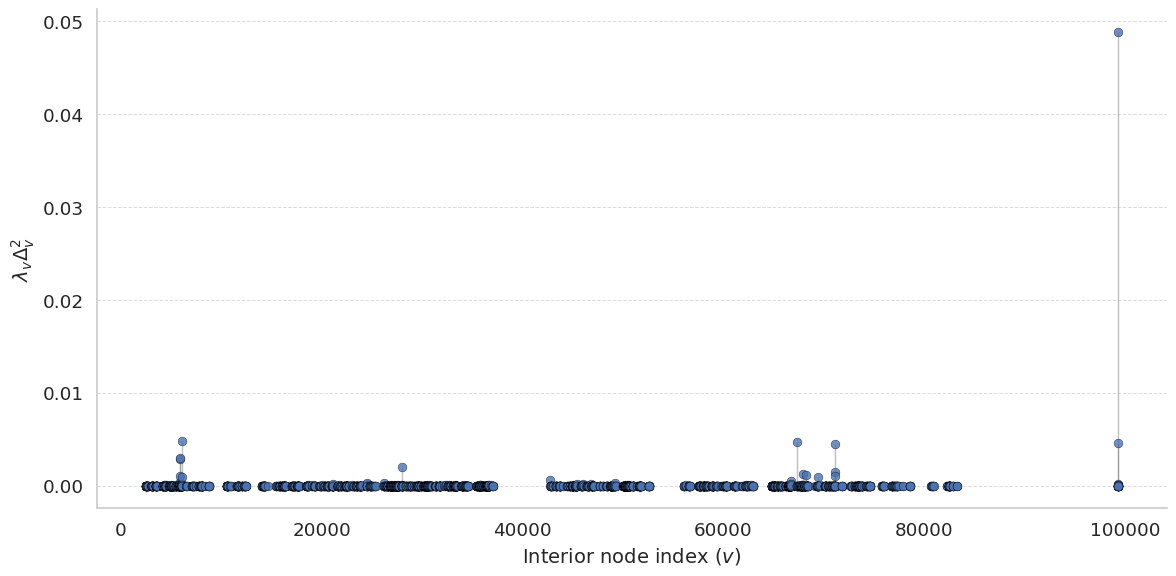

In [147]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx

# Scatter points with subtle edge for clarity
ax.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

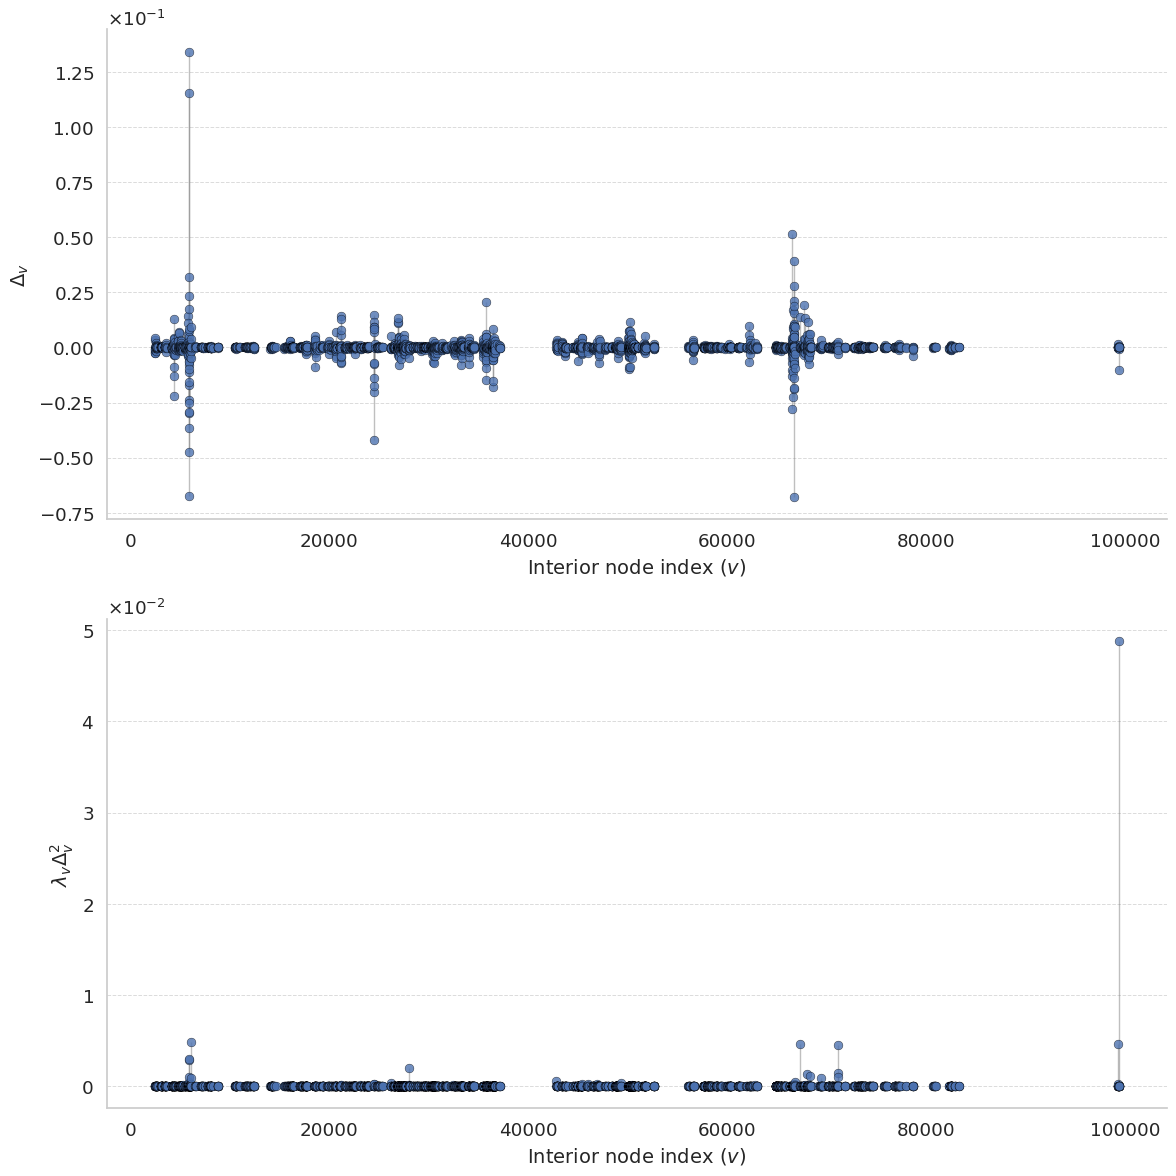

In [148]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
idx = np.where(hl_coords)[0]
y = hl_coords[idx]
x = idx
# Scatter points colored by value with better aesthetics
ax1.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Draw vertical lines behind scatter points
ax1.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
idx = np.where(dh_comps)[0]
y = dh_comps[idx]
x = idx
# Scatter points with subtle edge for clarity
ax2.scatter(
    x, y,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
# Vertical lines behind scatter points
ax2.vlines(
    x=x,
    ymin=0,
    ymax=y,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

### Compute level of significance

In [28]:
N = 10

intr_nodes = tree.find_interior_nodes()
subtree_sizes = tree.get_subtree_size()
subtree_starts = tree.find_subtree_start_indices()

sort_idx = np.argsort(dh_comps.data[:-1])[::-1]
indices = hl_coords.indices

#### Sampling without replacement

In [ ]:
def make_diff_rand():
    col1 = table_df['1200.GN09P.o'].sample(frac=1, random_state=None).reset_index(drop=True)
    col2 = table_df['1200.GN01P.o'].sample(frac=1, random_state=None).reset_index(drop=True)

    diff_rand_s = col1 - col2

    mask = diff_rand_s != 0

    values = diff_rand_s[mask].values
    indices = table_df['Leaf Index'][mask].values
    indptr = [0, len(values)]

    diff_rand = csc_matrix((values, indices, indptr), shape=(n_leaves, 1)).toarray()

    return diff_rand

def make_sorted_dh_comps_rand():
    diff_rand = make_diff_rand()
    hl_coords_rand = Q.T @ diff_rand

    diag = S.diagonal().reshape(-1, 1)
    dh_comps_rand = np.multiply(np.power(hl_coords_rand, 2), diag)

    y = np.squeeze(dh_comps_rand)
    sort_idx = np.argsort(y)[::-1]

    return y[sort_idx]

def make_sorted_dh_comps_rand_avg(N):
    total = make_sorted_dh_comps_rand()
    for _ in range(N - 1):
        total += make_sorted_dh_comps_rand()
    return total / N

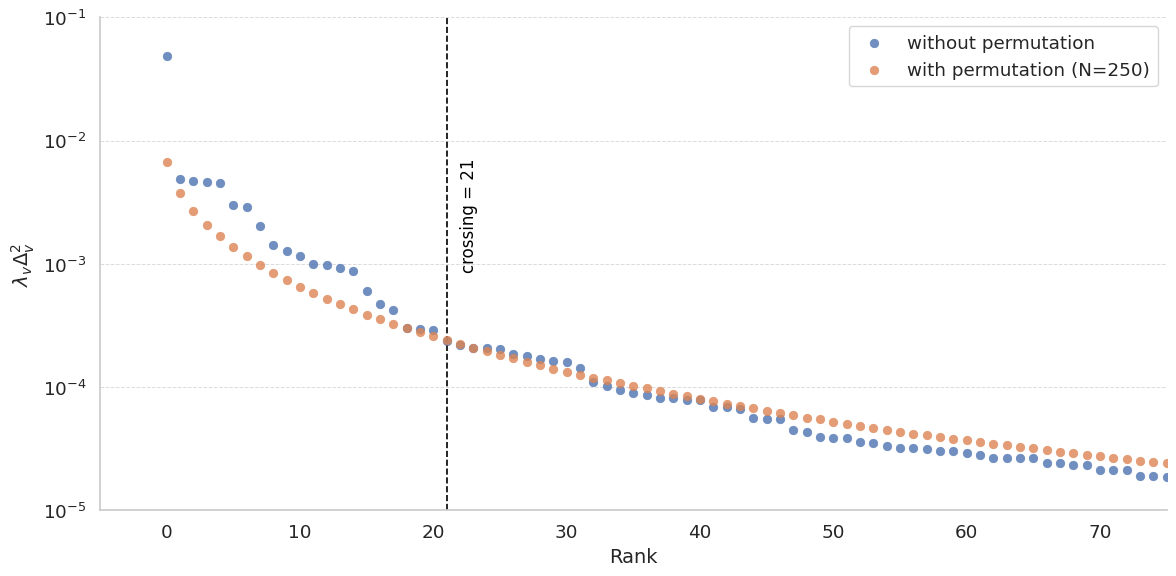

In [232]:
N = 250

sns.set(style="whitegrid", font_scale=1.2)

# Your data creation (replace with your actual functions/arrays)
y1 = make_sorted_dh_comps_rand_avg(N)
x1 = np.arange(y1.size)

y2 = np.squeeze(dh_comps.toarray())
sort_idx2 = np.argsort(y2)[::-1]
x2 = np.arange(y2.size)
y2_sorted = y2[sort_idx2]

# Find the first crossing point where y1 > y2
cross_idx = np.argmax(y1 > y2_sorted)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points
ax.scatter(
    x2,
    y2_sorted,
    s=40,
    alpha=0.8,
    linewidth=0.3,
    zorder=3,
    label='without permutation'
)
ax.scatter(
    x1,
    y1,
    s=40,
    alpha=0.8,
    linewidth=0.3,
    zorder=3,
    label=f'with permutation (N={N})'
)

# Add vertical dashed line + annotation
if y1[cross_idx] > y2_sorted[cross_idx]:
    ax.axvline(cross_idx, color="black", linestyle="--", linewidth=1.2, zorder=2)

    # Add vertical text along the line
    ax.text(
        cross_idx + 1,                # a bit to the right of the line
        2.5e-3,  # middle of log scale
        f'crossing = {cross_idx}',
        rotation=90,
        va='center',
        ha='left',
        fontsize=12,
        color="black"
    )

# Labels
ax.set_xlabel('Rank', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Scale and limits
ax.set_yscale('log')
ax.set_xlim([-5, 75])
ax.set_ylim([1e-5, 1e-1])

# Remove top and right spines
sns.despine()

ax.legend()

plt.tight_layout()
plt.show()

#### Random topology CDF

In [49]:
start_time = time.time()

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 48)

for rank in range(N):
    idx = sort_idx[rank]
    node_idx = intr_nodes[idx]
    start = subtree_starts[node_idx]
    width = subtree_sizes[node_idx]
    func = diff[start:start + width].toarray().reshape(-1)
    cdf_val = pcms.haar.cdf_proj_cbst(
        dh_comps[idx], 
        f=func,
        eps=0.005,
        delta=0.01,
        batch_size=1000
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    intr_node_idx = indices[idx]
    print(f"{intr_node_idx+1:>10} {subtree_sizes[idx]:>14} {dh_comps[idx]:>10.4f} {pval:>10.3e}")

print("\nElapsed time: ", time.time() - start_time)

     Index   Subtree Size  Component    P-Value
------------------------------------------------


ValueError: setting an array element with a sequence.

#### Difference of Dirichlet CDF

In [240]:
start = time.time()

pvals_dod = np.zeros(hl_coords.data.shape)
for i_idx, j_idx in enumerate(tree.find_interior_nodes()[hl_coords.indices]):
    children = tree.find_children(j_idx)
    if children.size == 1:
        pvals_dod[i_idx] = 1.0
    else:
        cdf_val = pcms.haar.cdf_proj_dod(
            hl_coords.data[i_idx], 
            tree=tree,
            node=j_idx,
            eps=0.01,
            delta=0.01
        )
        pvals_dod[i_idx] = 2 * min(cdf_val, 1 - cdf_val)

print("Elapsed time: ", time.time() - start)

Elapsed time:  20.07043766975403


In [241]:
alpha = 0.05
do_reject_dod = pvals_dod < alpha

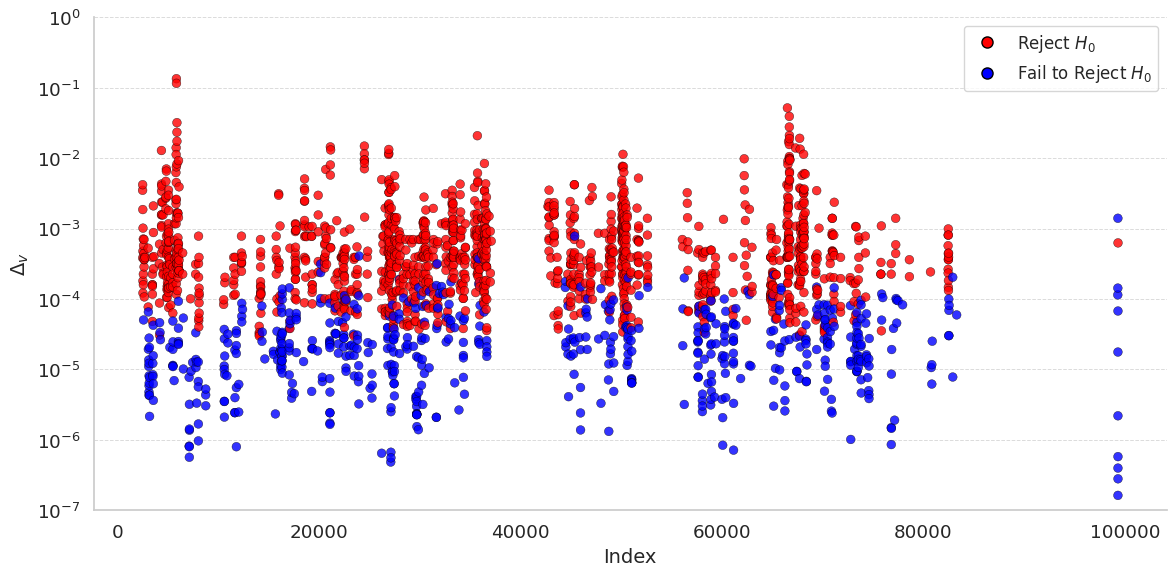

In [242]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter with edge and higher zorder
scatter = ax.scatter(
    hl_coords.indices[:-1],
    hl_coords.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Use log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-7, 1])

# Custom legend with clearer labels and markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Axis labels
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel(r'$\Delta_{v}$', fontsize=14)

# Add y-axis grid only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove clutter
sns.despine()

plt.tight_layout()
plt.show()

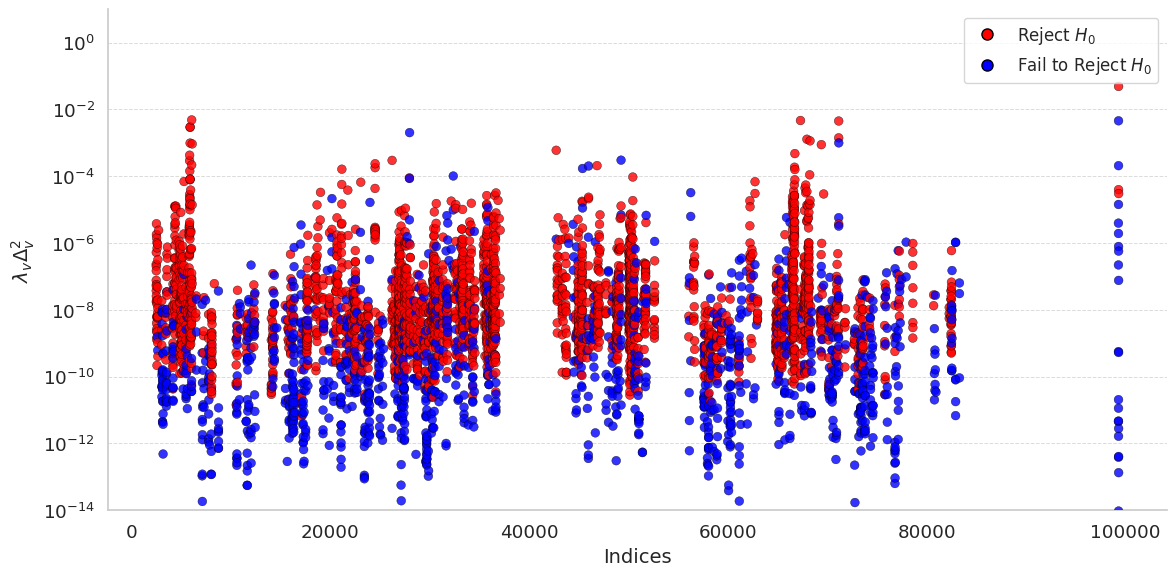

In [243]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to binary colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    dh_comps.indices[:-1],
    dh_comps.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e1])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [246]:
sort_idx

array([4259,  377, 3686, ..., 2079, 3740, 1958], shape=(4270,))

In [257]:
N = 10

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 60)

eps = 0.005
delta = 0.001

n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    intr_node_idx = dh_comps.indices[idx]
    node_idx = intr_nodes[intr_node_idx]
    cdf_val = pcms.haar.cdf_proj_dod(
        hl_coords.data[idx], 
        tree=tree,
        node=node_idx,
        eps=eps,
        delta=delta
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    pval = pval if pval > 0 else 0.5 / n_samples
    print(
        f"{intr_node_idx+1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{dh_comps.data[idx]:>10.4f} "
        f"{pval:>10.3e}"
    )

     Index   Subtree Size  Component    P-Value
------------------------------------------------------------
     99311          95297     0.0488  3.289e-06
      6079           1792     0.0048  3.289e-06
     67317            835     0.0047  3.289e-06
     99307          50035     0.0046  3.750e-01
     71160          14472     0.0045  4.868e-04
      5923            600     0.0030  3.289e-06
      5921            240     0.0029  3.289e-06
     27998          20765     0.0020  1.394e-01
     71159           4899     0.0014  3.289e-06
     67959           1477     0.0013  3.289e-06


In [259]:
for rank in range(N):
    idx = sort_idx[rank]
    print(f"{hl_coords.data[idx]:.2e}")

-1.02e-02
9.21e-03
1.39e-02
1.40e-03
-2.89e-03
1.73e-02
3.19e-02
-1.46e-03
2.36e-03
5.68e-03


#### Uniform Difference CDF

In [ ]:
N = 10

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 60)

eps = 0.005
delta = 0.001

n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    intr_node_idx = indices[idx]
    node_idx = intr_nodes[intr_node_idx]

    lamv = S.diagonal()[intr_node_idx]
    T = np.sqrt(dh_comps.data[idx] / lamv)
    wavelet = Q[:,intr_node_idx].data
    b = 2 * np.linalg.norm(wavelet) / np.max(np.abs(wavelet))
    sig2 = b**2 / 4
    pval = 2 * np.exp(-T**2 / (2 * sig2 + 2 * b * T / 3))

    print(
        f"{intr_node_idx+1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{dh_comps.data[idx]:>10.4f} "
        f"{pval:>10.3e}"
    )

     Index   Subtree Size  Component    P-Value
------------------------------------------------------------
     99311          95297     0.0488  2.000e+00
      6079           1792     0.0048  2.000e+00
     67317            835     0.0047  1.999e+00
     99307          50035     0.0046  2.000e+00
     71160          14472     0.0045  2.000e+00
      5923            600     0.0030  1.999e+00
      5921            240     0.0029  1.996e+00
     27998          20765     0.0020  2.000e+00
     71159           4899     0.0014  2.000e+00
     67959           1477     0.0013  2.000e+00


### Taxonomic classification of splits

In [159]:
intr_nodes = tree.find_interior_nodes()
subtree_starts = tree.find_subtree_start_indices()[intr_nodes]
subtree_sizes = tree.get_subtree_size()[intr_nodes]


def tax_of_split(idx, abunds):
    tax_map_left = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_child(interior_nodes[idx]), abunds=abunds)
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, node=tree.get_sibling(tree.get_child(interior_nodes[idx])), abunds=abunds)
    return tax_map_left, tax_map_right


def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    """
    Truncate an LCR string from the left by keeping only the last `max_ranks` ranks.
    Prepend with '...' if any ranks were removed.
    """
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        return '...;' + ';'.join(ranks[-max_ranks:])
    else:
        return lcr


def format_tax_table(idxs, abunds, max_ranks=3, file=sys.stdout):
    node_blocks = []

    # First pass: collect truncated LCRs and abundance lines
    for idx in idxs:
        left, right = tax_of_split(idx, abunds)
        left_abund_lines = [
            f"{tax}:{row.ref_fracs:.3f} ({row.abund_fracs:+.3f})"
            for tax, row in left['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]
        right_abund_lines = [
            f"{tax}:{row.ref_fracs:.3f} ({row.abund_fracs:+.3f})"
            for tax, row in right['Fracs'].iterrows()
            if round(row.ref_fracs, 2) > 0.0
        ]

        left_lcr_trunc = truncate_lcr(left['LCR'], max_ranks)
        right_lcr_trunc = truncate_lcr(right['LCR'], max_ranks)

        node_blocks.append((idx, left_lcr_trunc, right_lcr_trunc, left_abund_lines, right_abund_lines))

    # Compute column widths across all nodes after truncation
    left_max_width = max(len(block[1]) for block in node_blocks)  # LCR
    right_max_width = max(len(block[2]) for block in node_blocks)
    # Also consider abundances
    for _, _, _, left_abund, right_abund in node_blocks:
        if left_abund:
            left_max_width = max(left_max_width, max(len(l) for l in left_abund))
        if right_abund:
            right_max_width = max(right_max_width, max(len(r) for r in right_abund))
    left_max_width += 4
    right_max_width += 4

    # Print table
    for idx, left_lcr, right_lcr, left_abund_lines, right_abund_lines in node_blocks:
        # Pad abundance lines
        max_lines = max(len(left_abund_lines), len(right_abund_lines))
        left_abund_lines += [""] * (max_lines - len(left_abund_lines))
        right_abund_lines += [""] * (max_lines - len(right_abund_lines))

        # Node header
        print(f"Node {idx+1}", file=file)
        print(f"{'Left subtree':<{left_max_width}}{'Right subtree':<{right_max_width}}", file=file)
        print(f"{'-'*left_max_width}{'-'*right_max_width}", file=file)

        # LCR line
        print(f"{left_lcr:<{left_max_width}}{right_lcr:<{right_max_width}}", file=file)

        # Abundance lines
        for l_line, r_line in zip(left_abund_lines, right_abund_lines):
            print(f"{l_line:<{left_max_width}}{r_line:<{right_max_width}}", file=file)

        print("", file=file)  # Blank line between nodes

In [160]:
idxs = [99310, 6078, 67316, 99306, 71159, 5922, 5920, 27997, 71158, 67958]
with open("../data/tax_table_output.txt", "w") as f:
    format_tax_table(idxs, abunds=diff, max_ranks=2, file=f)